In [1]:
# Original code from: https://easy.gems.dkrz.de/Processing/healpix/healpix_cartopy.html
# With some additions.
import intake
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpix as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


In [2]:
import easygems.healpix as egh

In [3]:
data = xr.open_dataset('/home/markmuetz/mirrors/jasmin/gws/nopw/j04/hrcm/cache/torau/Lorenzo_u-cu087/data/healpix/20200101T0000Z_pfu4728.hpz9.nc')

In [4]:
data

<xarray.Dataset> Size: 604MB
Dimensions:  (t: 4, p: 6, cells: 3145728)
Coordinates:
  * t        (t) datetime64[ns] 32B 2020-07-16T06:00:00 ... 2020-07-17
  * p        (p) float64 48B 1e+03 850.0 700.0 600.0 500.0 250.0
Dimensions without coordinates: cells
Data variables:
    healpix  int32 4B ...
    u        (t, p, cells) float64 604MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.5
    history:      Thu Dec 19 10:27:29 2024: cdo -remapnn,hpz9 20200101T0000Z_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [5]:
def worldmap(var, **kwargs):
    # projection = ccrs.Robinson(central_longitude=0)
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    egh.healpix_show(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

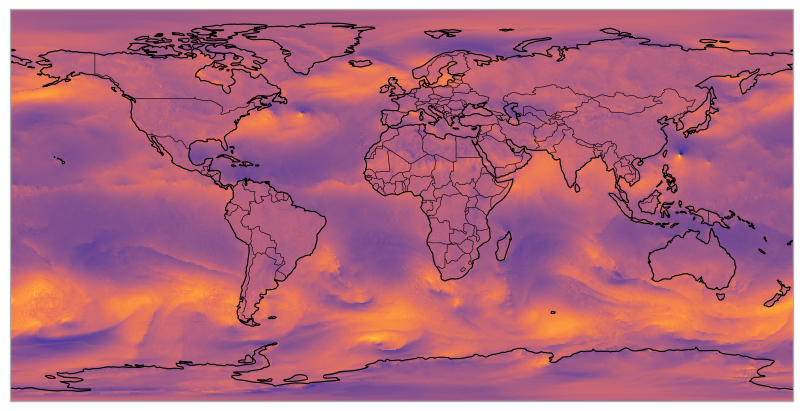

In [6]:
worldmap(data.u.isel(t=0, p=0), cmap=cmocean.cm.thermal)

In [7]:
d = data.u.isel(t=0, p=0).values

In [8]:
hp

<module 'healpix' from '/home/markmuetz/anaconda3/envs/wcrp_hackathon_env/lib/python3.12/site-packages/healpix/__init__.py'>

In [9]:
nside = egh.get_nside(data.u.isel(t=0, p=0))
lon, lat = hp.pix2ang(nside, np.arange(d.size), nest=True, lonlat=True)

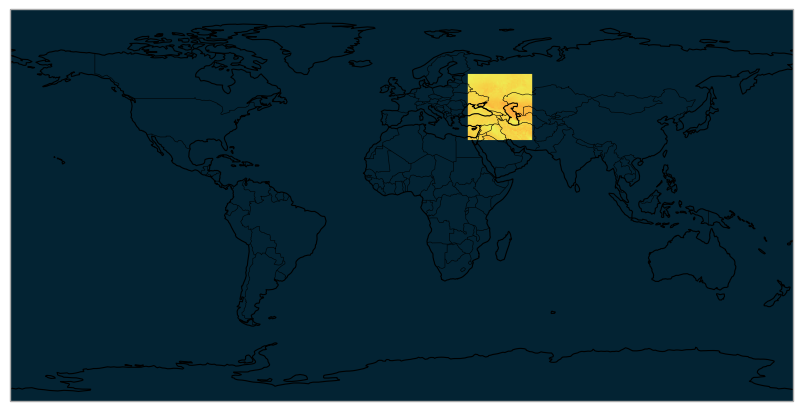

In [10]:
# Simple way of subsetting data.
m = (lon > 30) & (lon < 60) & (lat > 30) & (lat < 60)
d = data.u.isel(t=0, p=0)
d[~m] = -100
worldmap(d, cmap=cmocean.cm.thermal)


In [11]:
lon.shape

(3145728,)

In [12]:
# I am calling each of the 12 zoom-0 healpix levels a 'face'.
# These two funcs let you define the mapping between each face and the nested index at a given zoom.
def hp_face_level_next(a):
    a0 = np.arange(4).reshape((2, 2))
    tilesize = a.shape[0]
    return np.repeat(np.repeat(a, 2, axis=0), 2, axis=1) * 4 + np.tile(a0, (tilesize, tilesize))


def hp_face_level(zoom):
    a = np.arange(4).reshape((2, 2))
    for i in range(zoom - 1):
        a = hp_face_level_next(a)
    return a


In [13]:
# Get the (inverse) mapping between any cell and its place in a 2D grid for a single face.
a = np.arange(512**2)
f9 = hp_face_level(9)
idx = a[f9.flatten()]
a[idx].reshape(512, 512)

array([[     0,      1,      4, ...,  87377,  87380,  87381],
       [     2,      3,      6, ...,  87379,  87382,  87383],
       [     8,      9,     12, ...,  87385,  87388,  87389],
       ...,
       [174754, 174755, 174758, ..., 262131, 262134, 262135],
       [174760, 174761, 174764, ..., 262137, 262140, 262141],
       [174762, 174763, 174766, ..., 262139, 262142, 262143]])

In [14]:
# dd = d[:512**2][idx].reshape(512, 512)


In [15]:
d = data.u.isel(t=0, p=0).values

In [16]:
d.shape, idx.shape

((3145728,), (262144,))

In [17]:
# extract the data from the first face (dd) as well as the lat/lon values.
dd = d[:512**2][idx].reshape(512, 512)
lat1 = lat[:512**2][idx].reshape(512, 512)
lon1 = lon[:512**2][idx].reshape(512, 512)

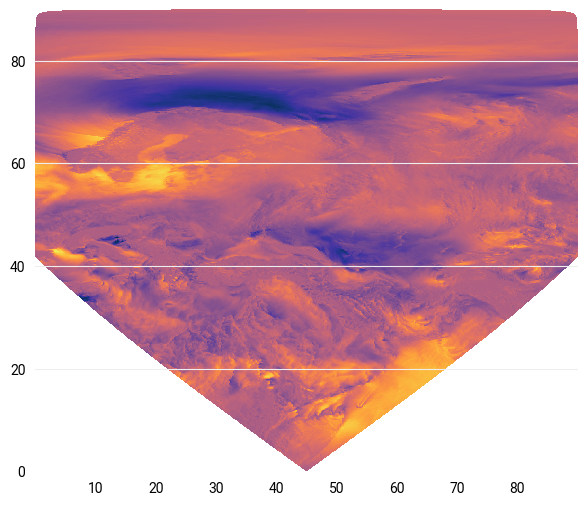

In [18]:
plt.pcolormesh(lon1, lat1, dd, cmap=cmocean.cm.thermal)


In [ ]:

# Plot data for all faces using pcolormesh. Marginally faster than imshow (used below).
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree()}, layout='constrained')
# fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.Robinson(central_longitude=0)}, layout='constrained')
offset = 512**2
minv = d.min()
maxv = d.max()
for i in range(12):
    if i in [-1]:
        continue
    dd = d[i * offset:(i + 1) * offset][idx].reshape(512, 512)
    lat1 = lat[i * offset:(i + 1) * offset][idx].reshape(512, 512)
    lon1 = lon[i * offset:(i + 1) * offset][idx].reshape(512, 512)
    # lat1, lon1 are centroid locations. I think you would get better results by defining edges.
    ax.pcolormesh(lon1, lat1, dd, cmap=cmocean.cm.thermal, vmin=minv, vmax=maxv)
ax.coastlines()


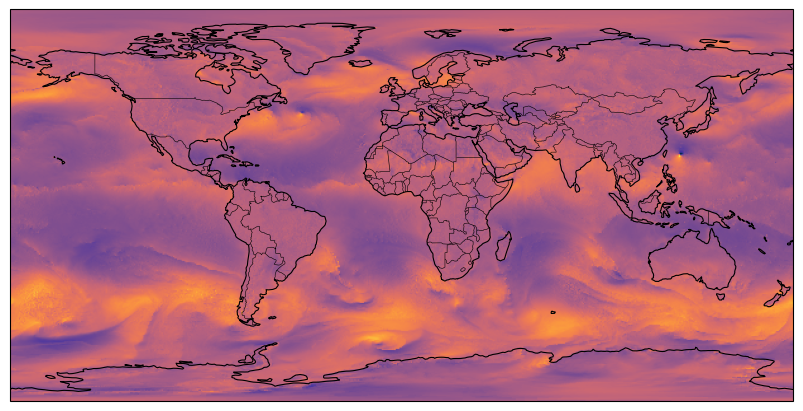

In [50]:
worldmap(data.u.isel(t=0, p=0), cmap=cmocean.cm.thermal)


In [34]:
d2 = np.zeros(256**2 * 12)
for i in range(12):
    d2[i * 256**2:(i + 1) * 256**2] = d[i * 512**2:(i + 1) * 512**2].reshape(256, 2, 256, 2).mean(axis=(1, 3)).ravel()
    
d3 = np.zeros(128**2 * 12)
for i in range(12):
    d3[i * 128**2:(i + 1) * 128**2] = d2[i * 256**2:(i + 1) * 256**2].reshape(128, 2, 128, 2).mean(axis=(1, 3)).ravel()


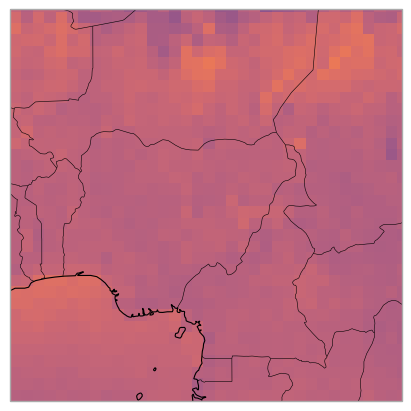

In [64]:
worldmap(d, cmap=cmocean.cm.thermal)
plt.gca().set_extent((0, 20, 0, 20))

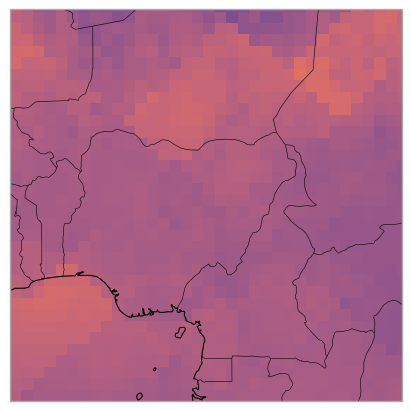

In [65]:
worldmap(d3, cmap=cmocean.cm.thermal)
plt.gca().set_extent((0, 20, 0, 20))

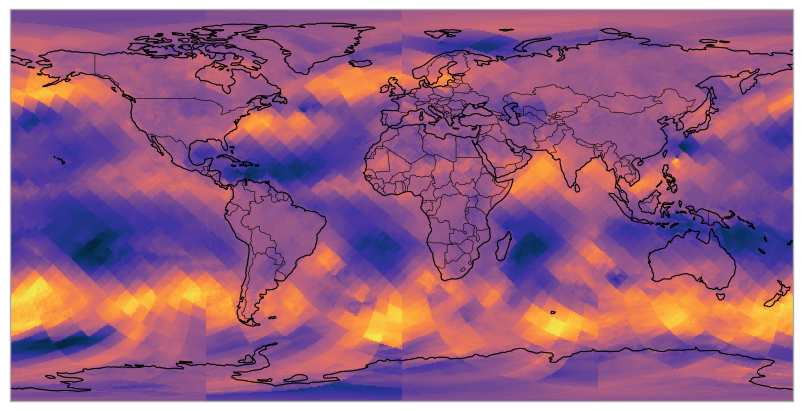

In [35]:
worldmap(d3, cmap=cmocean.cm.thermal)

In [37]:

d.mean(), d2.mean(), d3.mean()

(-0.21934100652613142, -0.21934100652613173, -0.21934100652613164)

In [70]:
def hp_coarsen(data):
    assert data.size % 12 == 0 and data.size // 12 % 4 == 0
    level = int(np.log2(int(np.sqrt(data.size // 12))))
    #print(level)
    nedge = 2**level
    nedge_m1 = 2**(level - 1)

    data_m1 = np.empty(12 * 4**(level - 1))
    for i in range(12):
        # not right - because of reshape to 4D?
        # data_m1[i * nedge_m1**2:(i + 1) * nedge_m1**2] = data[i * nedge**2:(i + 1) * nedge**2].reshape(nedge_m1, 2, nedge_m1, 2).mean(axis=(1, 3)).ravel()
        data_m1 = data.reshape(-1, 4).mean(axis=1)
    return data_m1

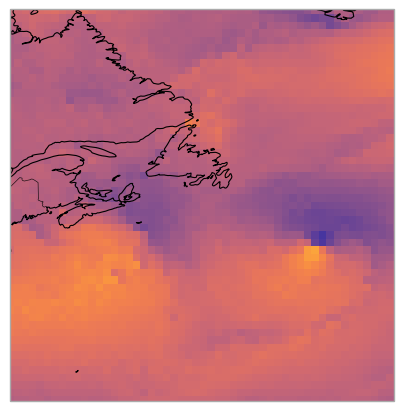

In [68]:
worldmap(d, cmap=cmocean.cm.thermal)
plt.gca().set_extent((-70, -40, 30, 60))

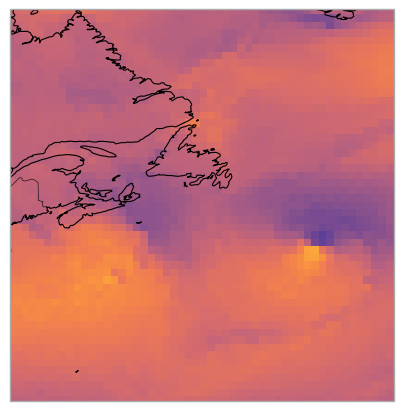

In [71]:
worldmap(hp_coarsen(d), cmap=cmocean.cm.thermal)
plt.gca().set_extent((-70, -40, 30, 60))

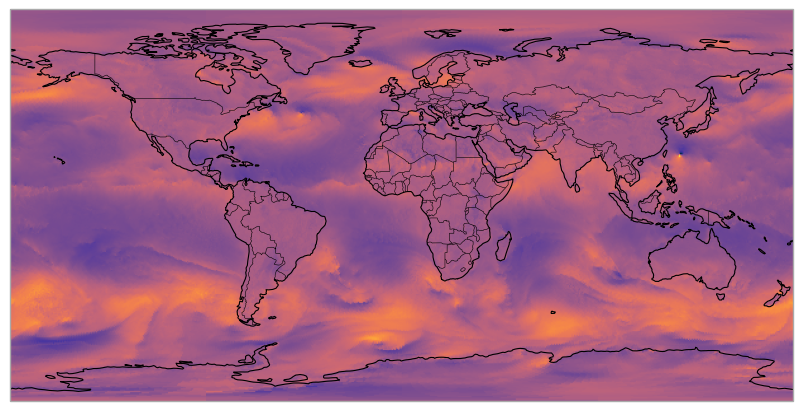

In [72]:
worldmap(hp_coarsen(hp_coarsen(d)), cmap=cmocean.cm.thermal)

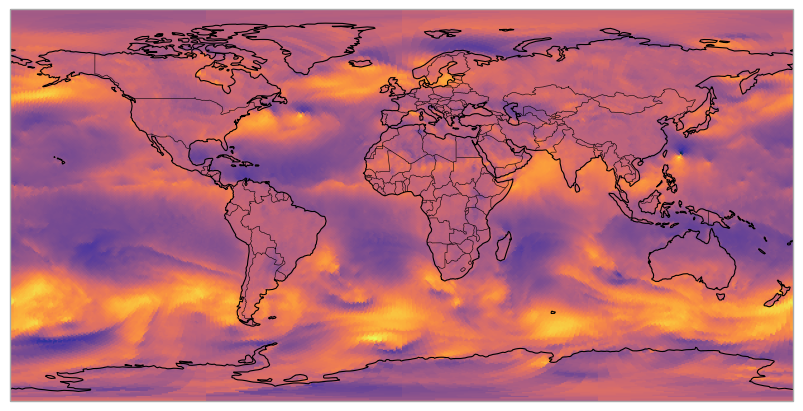

In [73]:
worldmap(hp_coarsen(hp_coarsen(hp_coarsen(d))), cmap=cmocean.cm.thermal)

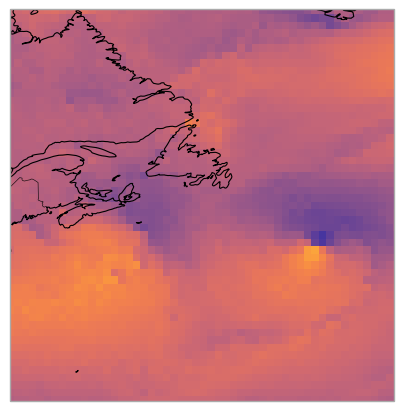

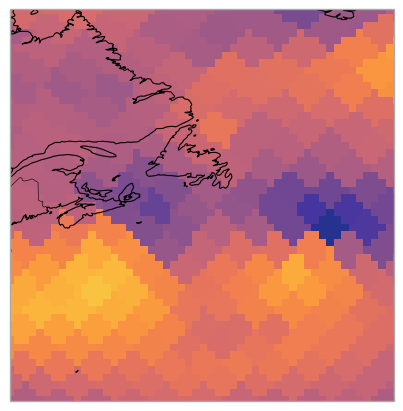

In [95]:
dc = d.copy()
for i in range(4):
    dc = hp_coarsen(dc)

kwargs = {'cmap': cmocean.cm.thermal}

fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_global()

kwargs = {'cmap': cmocean.cm.thermal}
egh.healpix_show(d, ax=ax, **kwargs)
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)
ax.set_extent((-70, -40, 30, 60))

fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_global()

egh.healpix_show(dc, ax=ax, **kwargs)
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)
ax.set_extent((-70, -40, 30, 60))

In [51]:
data.u.size, hp.npix2nside(data.u.size)

(75497472, -1)

In [52]:
hp.npix2nside??

In [53]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
experiment = cat.ICON["ngc3028"]

In [54]:
# Fails because data not stored locally.
data = experiment(time="P1D", zoom=7).to_dask()
worldmap(data.tas.isel(time=0), cmap=cmocean.cm.thermal)

FileNotFoundError: Unable to find group: file:///fastdata/ka1081/nextgems_cycle3/ngc3028/ngc3028_P1D_0.zarr